# Проект промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат  решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

**Описание легирования стали**

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

- Для оценки качества моделей применяйте метрику MAE.
- Значение метрики MAE должно быть меньше 6,8.

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor

In [ ]:
warnings.simplefilter(action='ignore')

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print('google.colab недоступен')

try:
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  print('google.colab недоступен')

google.colab недоступен
google.colab недоступен


### Открыть файлы

In [ ]:
#open file in colab or in yandex practicum
def open_csv(name):
  try:
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/industry/'+name)
  except:
    data = pd.read_csv('/datasets/'+name)

  return data

In [ ]:
#tempretures
temp = open_csv('data_temp_new.csv')
temp.columns = ['key', 'date_time', 'temp']

#heating
arc = open_csv('data_arc_new.csv')
arc.columns = ['key', 'heat_start', 'heat_end', 'power_act', 'power_react']

#bulk materials volumes
bulk = open_csv('data_bulk_new.csv')
bulk_cols = ['bulk1', 'bulk2', 'bulk3', 'bulk4', 'bulk5', 'bulk6', 'bulk7', 'bulk8', 'bulk9', 'bulk10', 'bulk11', 'bulk12', 'bulk13', 'bulk14', 'bulk15']
bulk.columns = ['key'] + bulk_cols

#bulk materials time
#bulk_time = open_csv('data_bulk_time_new.csv')
#bulk_time.columns = ['key'] + bulk_cols

#wire materials
wire = open_csv('data_wire_new.csv')
wire_cols = ['wire1', 'wire2', 'wire3', 'wire4', 'wire5', 'wire6', 'wire7', 'wire8', 'wire9']
wire.columns = ['key'] + wire_cols

#wire materials time
#wire_time = open_csv('data_wire_time_new.csv')
#wire_time.columns = ['key'] + wire_cols

#gas purging
gas = open_csv('data_gas_new.csv')
gas.columns = ['key', 'gas1']


### Функции

In [ ]:
#print analysis report of table
def print_report(data, table_name):
    print('Analysis report of "'+table_name+'" table')
    print('====================================================================================================')
    display(data.info())
    display(data.describe())
    display(data.head())
    print('')
    print('')

In [ ]:
def get_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    data = data[(data[column] < lower) | (data[column] > upper)]

    return data

In [ ]:
def del_keys(data, rows_to_delete):
    keys_to_delete = rows_to_delete['key'].unique()
    rows_to_delete = data[data['key'].isin(keys_to_delete)]
    data = data.drop(index=rows_to_delete.index)

    return data

In [ ]:
def print_delete_info(data, rows_to_delete):
    keys_to_delete = rows_to_delete['key'].unique()
    rows_to_delete = data[data['key'].isin(keys_to_delete)]['key'].count()
    print('всего уникальных ключей в датафрейме:', len(data['key'].unique()) )
    print('кол-во уникальных ключей к удалению:', len(keys_to_delete))
    print('процент уникальных ключей к удалению:', len(keys_to_delete)/len(data['key'].unique())*100)
    print('')
    print('кол-во записей к удалению:', rows_to_delete)

In [ ]:
# агрегирование данных и обработка выбросов
def agg_bulk_wire(data, column, cols):
    data_agg = data.groupby('key').sum(cols)
    data_agg = data_agg.sum(axis=1)
    data_agg = pd.DataFrame({'key':data_agg.index, column:data_agg.values})

    return data_agg

In [ ]:
def get_best_estimator(model, params, scoring, features, target, cv):
    GSCV = GridSearchCV(model, params,
                        cv = cv, # количество разбиений на кросс-валидацию
                        scoring = scoring,
                        n_jobs=-1
                       )
    GSCV.fit(features, target)
    print(GSCV.best_estimator_)
    print('Лучшие гипепрпараметры:', GSCV.best_params_)
    print('MAE:', -GSCV.best_score_)
    return GSCV.best_estimator_

### Первичный анализ таблиц

#### Таблица температур

In [ ]:
print_report(temp, 'temp')

Analysis report of "temp" table
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        18092 non-null  int64  
 1   date_time  18092 non-null  object 
 2   temp       14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,temp
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


,key,date_time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [ ]:
temp['date_time'] = pd.to_datetime(temp['date_time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
temp = temp.dropna()
temp = temp.drop_duplicates()

<function matplotlib.pyplot.show(close=None, block=None)>

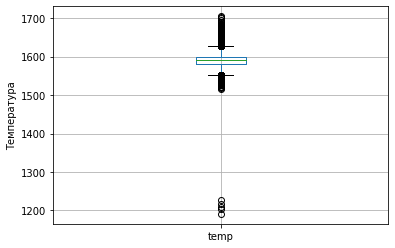

In [ ]:
bbplot = temp.boxplot(column=['temp'])
bbplot.set_ylabel('Температура')
plt.show

In [ ]:
outliers = temp[temp['temp'] < 1500]
len(outliers['key'].unique())

5

In [ ]:
print_delete_info(arc, outliers)

всего уникальных ключей в датафрейме: 3214
кол-во уникальных ключей к удалению: 5
процент уникальных ключей к удалению: 0.1555693839452396

кол-во записей к удалению: 22


In [ ]:
temp = del_keys(temp, outliers)

In [ ]:
#Удалим записи где у партии только 1 запись об измерении температуры
temp = temp.groupby('key').filter(lambda x: len(x) > 1)

In [ ]:
#Упорядочим по номеру партии и по времени, сделаем реиндекс
temp = temp.sort_values(by=['key', 'date_time']).reset_index(drop = True)

In [ ]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13903 entries, 0 to 13902
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        13903 non-null  int64         
 1   date_time  13903 non-null  datetime64[ns]
 2   temp       13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 326.0 KB


##### Сгруппируем данные

In [ ]:
temp['temp_count'] = temp.groupby('key')['key'].transform('count')

In [ ]:
temp_agg_all = temp.groupby('key')
temp_agg = temp_agg_all.head(1)[['key', 'temp']]
temp_agg = temp_agg.merge(temp_agg_all.tail(1), how='inner', on='key')
temp_agg.drop(['date_time'], axis=1, inplace=True)

In [ ]:
temp_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2470
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2471 non-null   int64  
 1   temp_x      2471 non-null   float64
 2   temp_y      2471 non-null   float64
 3   temp_count  2471 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 96.5 KB


In [ ]:
(temp_agg['temp_y']-temp_agg['temp_x']).describe()

count    2471.000000
mean        6.326993
std        23.055801
min       -98.000000
25%        -8.000000
50%         7.000000
75%        22.000000
max       105.000000
dtype: float64

#### Таблица нагрева

In [ ]:
print_report(arc, 'arc')

Analysis report of "arc" table
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          14876 non-null  int64  
 1   heat_start   14876 non-null  object 
 2   heat_end     14876 non-null  object 
 3   power_act    14876 non-null  float64
 4   power_react  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,power_act,power_react
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


,key,heat_start,heat_end,power_act,power_react
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [ ]:
arc['heat_start'] = pd.to_datetime(arc['heat_start'], format='%Y-%m-%d %H:%M:%S')
arc['heat_end'] = pd.to_datetime(arc['heat_end'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
arc = arc.dropna()
arc = arc.drop_duplicates()

In [ ]:
arc['power_ratio'] = arc['power_act'] / arc['power_react']

In [ ]:
#рассчитаем реактивную мощность, там где она меньше нуля или реактивная больше активной
mean_power_ratio = arc.loc[(arc['power_react']>0) & (arc['power_act']>0), 'power_act'].sum() / arc.loc[(arc['power_react']>0) & (arc['power_act']>0), 'power_react'].sum()

arc.loc[arc['power_react'] <= 0, 'power_react'] = arc['power_act'] / mean_power_ratio
arc.loc[arc['power_act'] < arc['power_react'], 'power_react'] = arc['power_act'] / mean_power_ratio

# и обновим коэфициент
arc['power_ratio'] = arc['power_act'] / arc['power_react']

In [ ]:
arc.describe()

,key,power_act,power_react,power_ratio
count,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.487118,1.373499
std,934.571502,0.258885,0.197606,0.130916
min,1.000000,0.223120,0.153777,1.001742
25%,806.000000,0.467115,0.337192,1.280145
50%,1617.000000,0.599587,0.441667,1.379768
75%,2429.000000,0.830070,0.608201,1.471216
max,3241.000000,1.463773,1.270284,1.857442


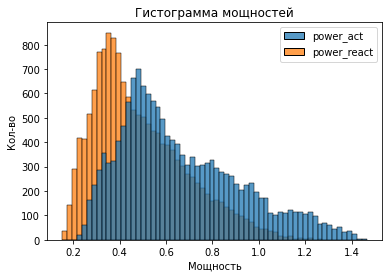

In [ ]:
columns = ['power_act', 'power_react']

ax = sns.histplot(arc[arc['power_react']>0][columns])
ax.set(xlabel='Мощность', ylabel='Кол-во', title='Гистограмма мощностей')
plt.show()

In [ ]:
# добавим столбец с продолжительностью
arc['duration'] = (arc['heat_end']-arc['heat_start']).astype('timedelta64[s]')

##### Удалим выбросы

Если есть выброс в "цикле замера температуры", то необходимо удалять всю партию. Выбросить 1 цикл из партии нельзя.

<function matplotlib.pyplot.show(close=None, block=None)>

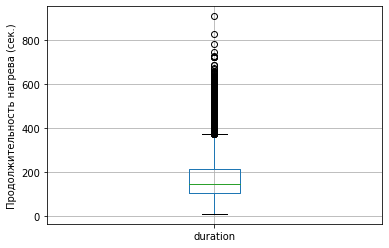

In [ ]:
bbplot = arc.boxplot(column=['duration'])
bbplot.set_ylabel('Продолжительность нагрева (сек.)')
plt.show

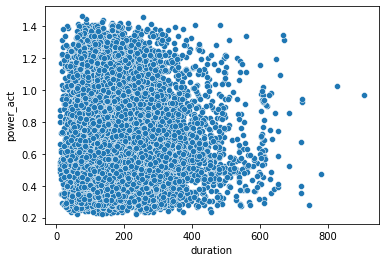

In [ ]:
sns.scatterplot(x = arc.duration, y = arc.power_act);

Какой-то зависимости продолжительности от мощности нет.

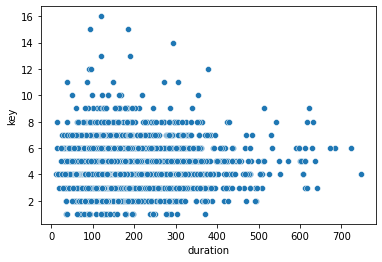

In [ ]:

sns.scatterplot(x = arc.duration, y = arc.groupby(['key'])['key'].count());

<function matplotlib.pyplot.show(close=None, block=None)>

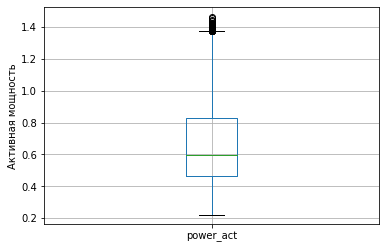

In [ ]:
bbplot = arc.boxplot(column=['power_act'])
bbplot.set_ylabel('Активная мощность')
plt.show

Из графика выбросы не кажутся аномалиями. Удалять не будем.

<function matplotlib.pyplot.show(close=None, block=None)>

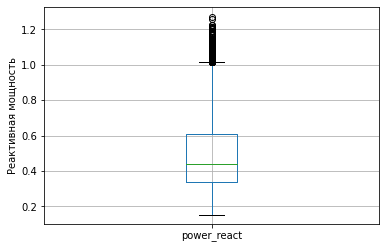

In [ ]:
bbplot = arc.boxplot(column=['power_react'])
bbplot.set_ylabel('Реактивная мощность')
plt.show

##### Сгруппируем данные

In [ ]:
arc_agg = arc.drop(['heat_start', 'heat_end', 'power_ratio'], axis= 1)
arc_agg = arc_agg.groupby('key').agg({'power_act': 'mean', 'power_react': 'mean', 'duration': ['sum', 'mean','count']})
arc_agg_cols = ['power_act', 'power_react', 'dur_sum', 'dur_avg', 'arc_count']
arc_agg.columns = arc_agg_cols
arc_agg['key'] = arc_agg.index
arc_agg = arc_agg.reset_index(drop=True)

In [ ]:
arc_agg.head()

,power_act,power_react,dur_sum,dur_avg,arc_count,key
0,0.607346,0.428564,1098.0,219.60,5,1
1,0.534852,0.363339,811.0,202.75,4,2
2,0.812728,0.587491,655.0,131.00,5,3
3,0.676622,0.514248,741.0,185.25,4,4
4,0.563238,0.421998,869.0,217.25,4,5


#### Таблица добавления сыпучих материалов

In [ ]:
print_report(bulk,'bulk')

Analysis report of "bulk" table
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3129 non-null   int64  
 1   bulk1   252 non-null    float64
 2   bulk2   22 non-null     float64
 3   bulk3   1298 non-null   float64
 4   bulk4   1014 non-null   float64
 5   bulk5   77 non-null     float64
 6   bulk6   576 non-null    float64
 7   bulk7   25 non-null     float64
 8   bulk8   1 non-null      float64
 9   bulk9   19 non-null     float64
 10  bulk10  176 non-null    float64
 11  bulk11  177 non-null    float64
 12  bulk12  2450 non-null   float64
 13  bulk13  18 non-null     float64
 14  bulk14  2806 non-null   float64
 15  bulk15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
bulk = bulk.dropna(thresh=1)
bulk = bulk.fillna(0)
bulk = bulk.drop_duplicates()

In [ ]:
bulk_agg = bulk.groupby('key').sum()
bulk_agg['key'] = bulk_agg.index
bulk_agg.reset_index(drop=True, inplace=True)
bulk_agg.head(5)

,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15,key
0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,1
1,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,2
2,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,3
3,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5


In [ ]:
print('Кол-во не нулевых значений:')
for column in bulk_cols:
    print(column, bulk_agg[bulk_agg[column] > 0][column].count())

Кол-во не нулевых значений:
bulk1 252
bulk2 22
bulk3 1298
bulk4 1014
bulk5 77
bulk6 576
bulk7 25
bulk8 1
bulk9 19
bulk10 176
bulk11 177
bulk12 2450
bulk13 18
bulk14 2806
bulk15 2248


<function matplotlib.pyplot.show(close=None, block=None)>

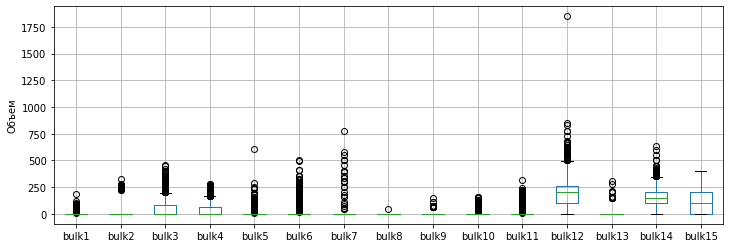

In [ ]:
#ящик с усами
bbplot = bulk_agg.boxplot(column=bulk_cols, figsize=(12 , 4))
bbplot.set_ylabel('Объем')
plt.show

In [ ]:
#отерзать выбросы
outliers = bulk_agg[bulk_agg['bulk12']>1750]
print_delete_info(bulk_agg, outliers)

всего уникальных ключей в датафрейме: 3129
кол-во уникальных ключей к удалению: 1
процент уникальных ключей к удалению: 0.03195909236177692

кол-во записей к удалению: 1


In [ ]:
#удалить
bulk_agg = del_keys(bulk_agg, bulk_agg[bulk_agg['bulk12'] > 1750])

#### Таблица добавления проволочных материалов

In [ ]:
print_report(wire,'wire')

Analysis report of "wire" table
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire1   3055 non-null   float64
 2   wire2   1079 non-null   float64
 3   wire3   63 non-null     float64
 4   wire4   14 non-null     float64
 5   wire5   1 non-null      float64
 6   wire6   73 non-null     float64
 7   wire7   11 non-null     float64
 8   wire8   19 non-null     float64
 9   wire9   29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wire = wire.dropna(thresh=1)
wire = wire.fillna(0)
wire = wire.drop_duplicates()

In [ ]:
wire_agg = wire.groupby('key').sum()
wire_agg['key'] = wire_agg.index
wire_agg.reset_index(drop=True, inplace=True)
wire_agg.head(5)

,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9,key
0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [ ]:
wire_agg[wire_agg['wire5'] > 0]

,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9,key
2440,18.30192,0.0,96.288193,0.0,15.132,73.307526,0.0,0.0,0.0,2567


In [ ]:
print('Кол-во не нулевых значений:')
for column in wire_cols:
    print(column, wire_agg[wire_agg[column] > 0][column].count())

Кол-во не нулевых значений:
wire1 3055
wire2 1079
wire3 63
wire4 14
wire5 1
wire6 73
wire7 11
wire8 19
wire9 29


<function matplotlib.pyplot.show(close=None, block=None)>

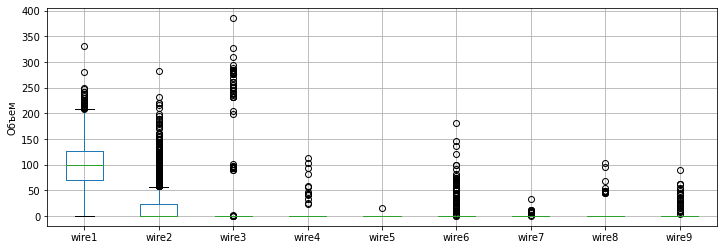

In [ ]:
#ящик с усами
bbplot = wire_agg.boxplot(column=wire_cols, figsize=(12 , 4))
bbplot.set_ylabel('Объем')
plt.show

In [ ]:
wire_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire1   3081 non-null   float64
 1   wire2   3081 non-null   float64
 2   wire3   3081 non-null   float64
 3   wire4   3081 non-null   float64
 4   wire5   3081 non-null   float64
 5   wire6   3081 non-null   float64
 6   wire7   3081 non-null   float64
 7   wire8   3081 non-null   float64
 8   wire9   3081 non-null   float64
 9   key     3081 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


#### Таблица продувки

In [ ]:
print_report(gas,'gas')

Analysis report of "gas" table
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas1    3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,gas1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
gas = gas.dropna()
gas = gas.drop_duplicates()

In [ ]:
gas_agg = gas.groupby('key').agg({'gas1':'sum'})
gas_agg['key'] = gas_agg.index
gas_agg = gas_agg.reset_index(drop=True)

<function matplotlib.pyplot.show(close=None, block=None)>

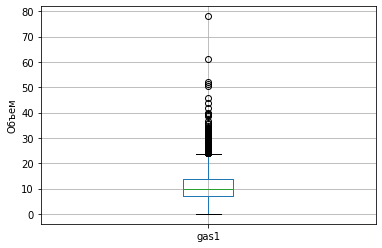

In [ ]:
bbplot = gas_agg.boxplot(column='gas1')
bbplot.set_ylabel('Объем')
plt.show

## Обучение моделей

### Подготовка выборок для обучения

In [ ]:
data = temp_agg.merge(arc_agg, how='inner', on='key')
data = data.merge(bulk_agg, how='inner', on='key')
data = data.merge(wire_agg, how='inner', on='key')
data = data.merge(gas_agg, how='inner', on='key')
data = data.set_index('key')

In [ ]:
data.describe()

,temp_x,temp_y,temp_count,power_act,power_react,dur_sum,dur_avg,arc_count,bulk1,bulk2,...,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9,gas1
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1587.351549,1593.356282,5.692771,0.664197,0.488923,807.239243,172.076725,4.692771,3.355422,1.425559,...,102.456265,17.532219,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795,11.350278
std,23.619106,11.202150,1.597005,0.128418,0.098024,338.734041,43.755372,1.597005,11.839550,19.102530,...,43.492736,33.463349,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248,6.245844
min,1519.000000,1541.000000,2.000000,0.267676,0.196228,57.000000,57.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008399
25%,1571.000000,1587.000000,5.000000,0.576159,0.420039,581.000000,141.000000,4.000000,0.000000,0.000000,...,73.268516,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.282534
50%,1587.000000,1593.000000,6.000000,0.655834,0.484669,778.000000,169.500000,5.000000,0.000000,0.000000,...,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10.100687
75%,1603.000000,1598.000000,7.000000,0.741883,0.546693,993.000000,198.750000,6.000000,0.000000,0.000000,...,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,14.216939
max,1660.000000,1653.000000,17.000000,1.243889,0.960763,4189.000000,378.000000,16.000000,94.000000,325.000000,...,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,60.935689


Таблица температур после удаления аномалий и группировки данных содержит 2471 партий.

После обработки других таблиц и объедения всех данных в конечный датафрейм получили 2324 партий.

**Процент удаленных партий**: 6%

**Построим графики рассеивания и тепловую карту для изучения зависимостей.**

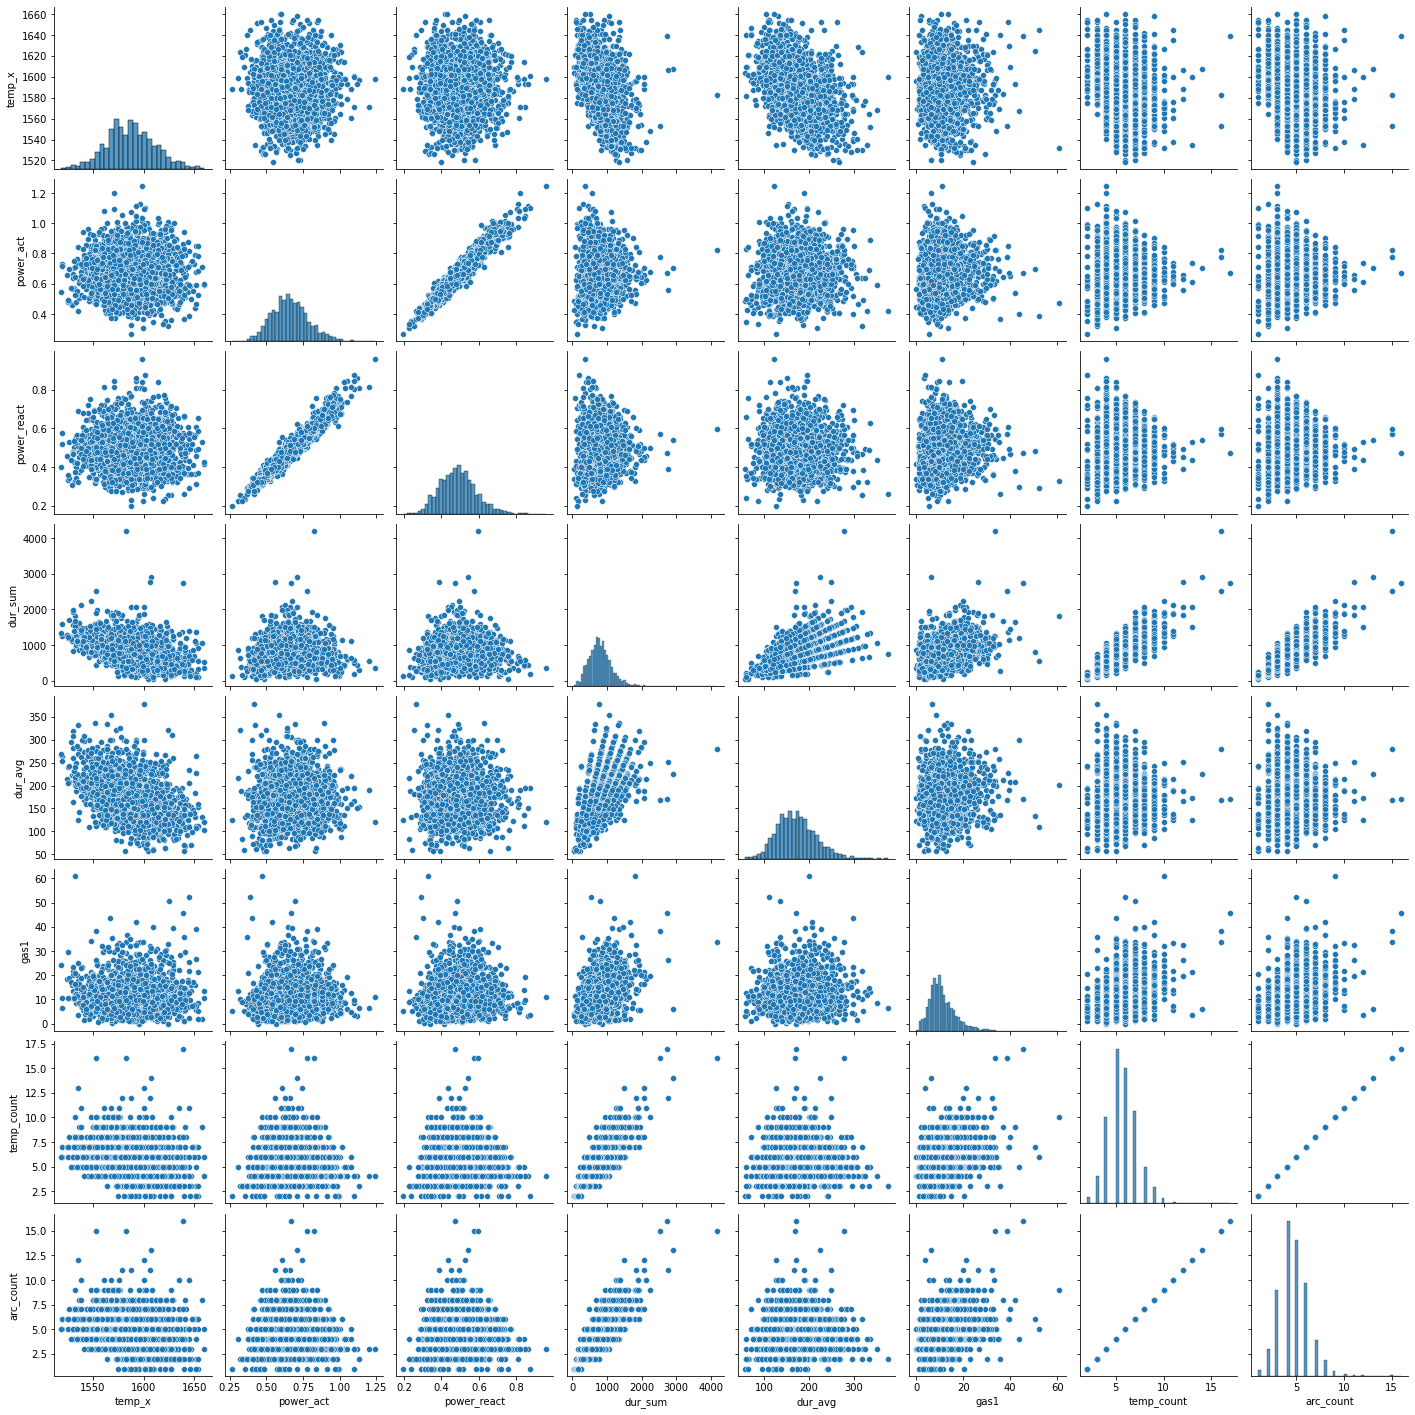

In [ ]:
data_plot = data[['temp_x', 'power_act', 'power_react', 'dur_sum', 'dur_avg', 'gas1', 'temp_count', 'arc_count']]
sns.pairplot(data_plot)

<AxesSubplot:>

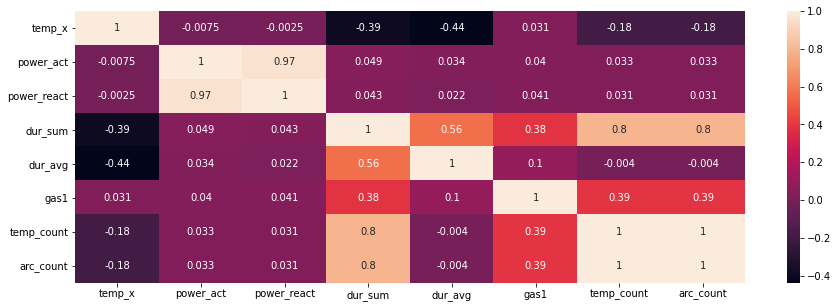

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(data[['temp_x', 'power_act', 'power_react', 'dur_sum', 'dur_avg', 'gas1', 'temp_count', 'arc_count']].corr(), cbar=True, annot=True)

- temp_x имеет сильную обратную корреляцию с продолжительностью нагрева
- power_act и power_react не имеют корреляций с данными
- dur_sum имеет сильную корреляцию с кол-вом циклов и сильную связь с продувкой газом
- dur_avg, temp_count, arc_count можно убрать, сильная коллинеальность в данных


<AxesSubplot:>

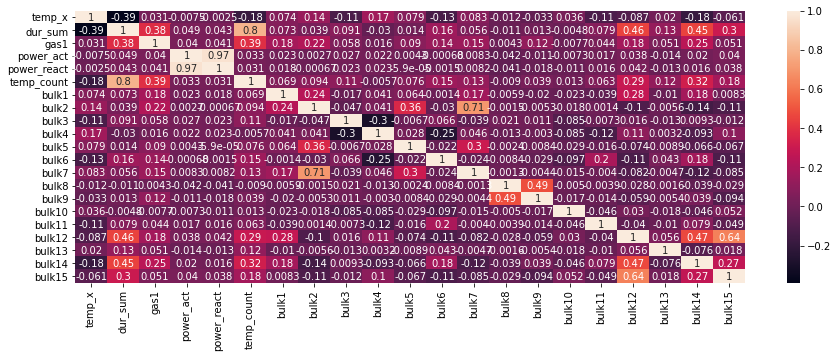

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(data[['temp_x', 'dur_sum', 'gas1', 'power_act', 'power_react', 'temp_count']+bulk_cols].corr(),\
            cbar=True, annot=True)

- bulk8 и bulk9 коррелируют только друг на друга.
- bulk10 не имеет корреляций
- bulk9 и bulk13 имеют очень слабые корреляции на продолжительность нагрева и на продувку

<AxesSubplot:>

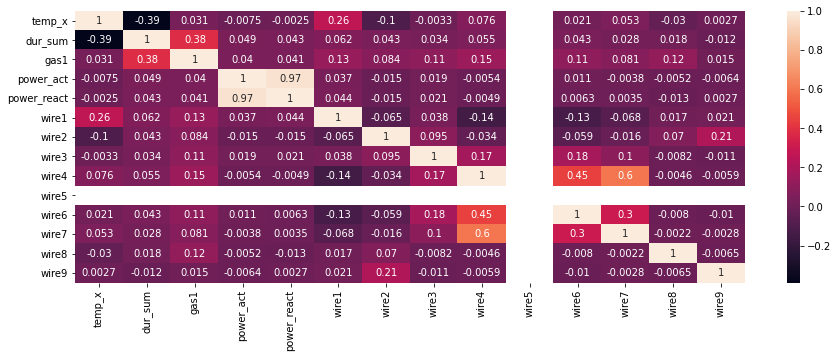

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(data[['temp_x', 'dur_sum', 'gas1', 'power_act', 'power_react']+wire_cols].corr(),\
            cbar=True, annot=True)

- wire5 - без корреляций
- wire8 - имеет слабую корреляцию

In [ ]:
RANDOM_STATE = 12923

drop_cols = ['temp_y','arc_count', 'temp_count', 'power_act', 'power_react', 'dur_avg', \
             'bulk8', 'bulk10', 'wire5']

features = data.drop(drop_cols, axis=1)
target = data['temp_y']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581 entries, 1881 to 786
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   temp_x   581 non-null    float64
 1   dur_sum  581 non-null    float64
 2   bulk1    581 non-null    float64
 3   bulk2    581 non-null    float64
 4   bulk3    581 non-null    float64
 5   bulk4    581 non-null    float64
 6   bulk5    581 non-null    float64
 7   bulk6    581 non-null    float64
 8   bulk7    581 non-null    float64
 9   bulk9    581 non-null    float64
 10  bulk11   581 non-null    float64
 11  bulk12   581 non-null    float64
 12  bulk13   581 non-null    float64
 13  bulk14   581 non-null    float64
 14  bulk15   581 non-null    float64
 15  wire1    581 non-null    float64
 16  wire2    581 non-null    float64
 17  wire3    581 non-null    float64
 18  wire4    581 non-null    float64
 19  wire6    581 non-null    float64
 20  wire7    581 non-null    float64
 21  wire8    581 

In [ ]:
features_columns = features_train.columns

In [ ]:
scaler = StandardScaler()

features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

### Линейная регрессия

In [ ]:
params={}

In [ ]:
model = LinearRegression()
model = get_best_estimator(model, params, 'neg_mean_absolute_error', features_train, target_train, cv=3)

LinearRegression()
Лучшие гипепрпараметры: {}
MAE: 6.639826403677797


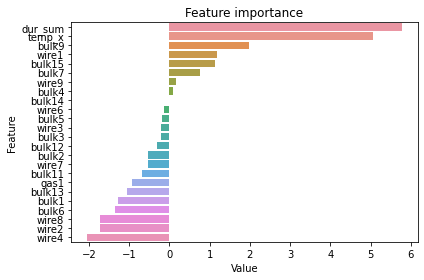

In [ ]:
feature_importance = model.coef_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

In [ ]:
%%time

model.fit(features_train, target_train)

CPU times: user 18 ms, sys: 4.5 ms, total: 22.5 ms
Wall time: 6.61 ms


LinearRegression()

In [ ]:
%%time

predicted_train = model.predict(features_train)

CPU times: user 13.4 ms, sys: 20.8 ms, total: 34.2 ms
Wall time: 73.3 ms


**Время обучения**
Wall time: 6.61 ms

**Время предсказания**
Wall time: 73.3 ms

**MAE** 6.639826403677797

### CatboostRegressor

In [ ]:
params = {
    "depth": [3,4],
    "learning_rate": [0.03, 0.01],
    "iterations": [800, 1000]
}

In [ ]:
model = CatBoostRegressor(loss_function='MAE', random_state=RANDOM_STATE)

In [ ]:
best_params = model.grid_search(params,
                          X=features_train,
                          y=target_train,
                          verbose=False,
                          cv=3,
                          plot=True
                         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1545.4115567	test: 1546.2381376	best: 1546.2381376 (0)	total: 1.18ms	remaining: 944ms
1:	learn: 1499.0966873	test: 1499.9152447	best: 1499.9152447 (1)	total: 2.29ms	remaining: 913ms
2:	learn: 1454.1584633	test: 1454.9716640	best: 1454.9716640 (2)	total: 3.28ms	remaining: 871ms
3:	learn: 1410.5650709	test: 1411.3745789	best: 1411.3745789 (3)	total: 4.23ms	remaining: 842ms
4:	learn: 1368.2612699	test: 1369.0718120	best: 1369.0718120 (4)	total: 5.22ms	remaining: 829ms
5:	learn: 1327.2296567	test: 1328.0336773	best: 1328.0336773 (5)	total: 6.16ms	remaining: 815ms
6:	learn: 1287.4455288	test: 1288.2453494	best: 1288.2453494 (6)	total: 7.07ms	remaining: 800ms
7:	learn: 1248.8605983	test: 1249.6534218	best: 1249.6534218 (7)	total: 7.9ms	remaining: 782ms
8:	learn: 1211.4189833	test: 1212.2068866	best: 1212.2068866 (8)	total: 8.84ms	remaining: 777ms
9:	learn: 1175.0758369	test: 1175.8566541	best: 1175.8566541 (9)	total: 9.94ms	remaining: 786ms
10:	learn: 1139.8574454	test: 1140.634386

MAE: 6.248818952

In [ ]:
best_params['params']

{'depth': 3, 'iterations': 800, 'learning_rate': 0.03}

In [ ]:
model = CatBoostRegressor(loss_function='MAE',
                          depth=3,
                          learning_rate=0.03,
                          iterations=800,
                          random_state=RANDOM_STATE)

In [ ]:
%%time

model.fit(features_train, target_train, verbose=False)

CPU times: user 877 ms, sys: 64.1 ms, total: 941 ms
Wall time: 3.01 s


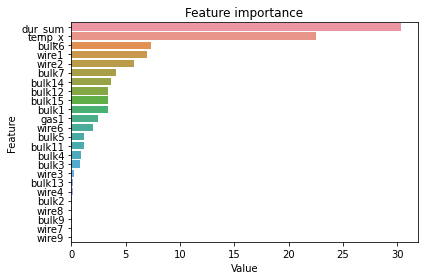

In [ ]:
feature_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

In [ ]:
%%time

predicted_train = model.predict(features_train)

CPU times: user 4.73 ms, sys: 56 µs, total: 4.78 ms
Wall time: 3.31 ms


**Время обучения**
Wall time: 3.01s

**Время предсказания**
Wall time: 3.31 ms

**MAE** 6.248818952

## Финальная модель

Обе модели удовлетворили условиям. CatBoostRegressor более точная, Линейная регрессия быстрее обучается.
Т.к. время обучения в обоих моделях достаточно маленькое: 3.01s и 6.61 ms соответственно, то выберем более точную модель.

In [ ]:
model = CatBoostRegressor(loss_function='MAE',
                          depth=3,
                          learning_rate=0.03,
                          iterations=800,
                          random_state=RANDOM_STATE)

In [ ]:
model.fit(features_train, target_train, verbose=False)

In [ ]:
predicted_test = model.predict(features_test)

In [ ]:
print('MAE:',mean_absolute_error(target_test, predicted_test))

MAE: 6.294678453368609


### Сравнение с DummyRegressor

In [ ]:
model = DummyRegressor()
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('MAE:',mean_absolute_error(target_test, predicted_test))

MAE: 8.27617724401417


## Отчет о проекте

### Определение проблемы

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО решил уменьшить потребление электроэнергии на этапе обработки стали. В проекте мы оптимизировали этап лигирования стали.

Задача машинного обучения состоит, в том, чтобы предсказать температуру стали после легирования.

### Показатели

Производительность моделей машинного обучения будет оцениваться на тестовом наборе. Тестовый набор это случайная выборка размером 25% от всех данных. Точность измеряется с помощью метрики MAE-средней абсолютной ошибки. MAE < 6.8 будет считаться приемлемым и подходящим для внедрения.

### Исходные данные

Набор данных был предоставлен предприятием.


Данные были разделены на несколько файлов:
- data_temp_new.csv - результаты измерения температуры - 18092 записей
- data_arc_new.csv - данные об электродах и нагреве - 14876 записей
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём) - 3129 записей
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время)
- data_wire_new.csv — данные о проволочных материалах (объём) - 3081 записей
- data_wire_time_new.csv — данные о проволочных материалах (время)
- data_gas_new.csv — данные о продувке сплава газом - 3239 записей

После обработки и объединения - набор данных составил 2324 записей. Набор данных был разделен на две выборки train = 1734(75%) и test 581(25%)

Одним из ограничений заказчика было - минимальная температура в партии не должна быть меньше 1500 градусов С.

Характеристики: начальная температура, продолжительность нагрева, объем газа при продувке, объем сыпучих материалов, объем проволочных материалов.

### Моделирование

#### Подготовка данных

**Обработка данных**: В проекте мы не использовали два файла с данными о времени подачи сыпучих и проволочных материалов. Так же мы проверили данные на пропуски. Для таблиц bulk и wire заполнили пропуски 0. В таблице с измерением температур мы удалили партии, в которых встречались температуры менее 1500 градусов. Так же удалили партии, в которых кол-во измерений температур было 1.

В таблице нагрева были скорректированы данные по мощности.  Для этого рассчитали отношение активной мощности и реактивной, нашли среднее значение и обновили значения, в записях, где реактивная мощность была меньше нуля или меньше активной мощности.

Мы проанализировали данные на выбросы. В результате аномалий не было обнаружено.

Далее обработанные данные мы объединили в единый набор данных по общему столбцу "key" и оставили партии, которые присутствовали во всех файлах.

**Корреляционный анализ данных**: мы провели анализ для выевления зависимостей в данных. в результате были выявлены характеристики, которые ни на что не влияли или дублирующие информацию. Такие характеристики при построении моделей были удалены:
- power_act и power_react не имеют корреляций с данными
- dur_avg, temp_count, arc_count можно убрать, сильная коллинеальность в данных
- bulk8, bulk10 не имеет корреляций
- wire5 - без корреляций

**Стандартизация числовых параметров**: Числовые характеристики были стандартизированы с использованием предварительной обработки Scikit-learn функция StandardScaler(). При применении преобразования к тестовому набору мы помещаем модель преобразования в обучающий набор, а затем преобразуем тестовый набор.

#### Обучение моделированию

Мы создали две модели с трехкратной перекрестной проверкой: линейную регрессию и градиентный бустинг.

**Оценка моделей**

Линейная регрессия:
- Время обучения Wall time: 6.61 ms
- Время предсказания Wall time: 73.3 ms
- MAE 6.639826403677797

Градиентный бустинг:
- Время обучения Wall time: 3.01s
- Время предсказания Wall time: 3.31 ms
- MAE 6.248818952

Обе модели удовлетворили условиям. Модель построенная с помощью градиентного бустинга более точная, Линейная регрессия быстрее обучается. Т.к. время обучения в обоих моделях достаточно маленькое: 3.01s и 6.61 ms соответственно, то выберем более точную модель - градиентный бустинг.

Модель градиентного бустинга была построена с помощью библотеки CatBoost. Для этой модели были подобраны гипермараметры:
- depth=3
- learning_rate=0.03
- iterations=800

Важность характеристик для модели градиентного бустинга показана ниже:

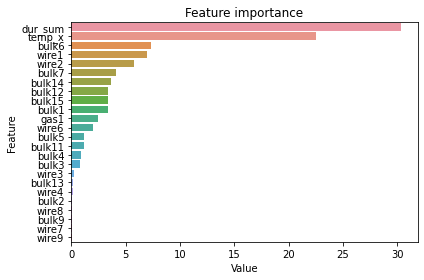

### Результаты
С помощью модели градиентного бустинга на тестовых данных было получено значение метрики MAE = 6.294678453368609.

Данную модель сравнили с моделью заглушкой, которая предсказывает результать без обучения. Для модели заглушки значение MAE = 8.27617724401417, что на много больше значения метрики для модели градиентного бустинга.

Таким образом, мы достигли выполнения поставленных задач и модель градиентного бустинга рекомендуется к внедрению.